In [1]:
from tree_detection_framework.preprocessing.preprocessing import create_dataloader
from tree_detection_framework.detection.detector import Detectree2Detector
from tree_detection_framework.detection.models import Detectree2Module
from tree_detection_framework.postprocessing.postprocessing import multi_region_NMS

/ofo-share/repos-amritha/conda/envs/tree-detection-framework2/lib/python3.10/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


In [2]:
dataloader = create_dataloader(
    raster_folder_path="/ofo-share/scratch-amritha/emerald_point_dtree2/dataset/emerald-point-ortho",
    # raster_folder_path="/ofo-share/scratch-derek/tdf-testing/",
    chip_size=512,
    chip_stride=400,
    batch_size=3,
    output_resolution=0.2,
)

2024-11-14 17:28:08,656 - INFO - Units = Units.PIXELS
2024-11-14 17:28:08,657 - INFO - Stride = 400


In [3]:
trained_model = "/ofo-share/repos-amritha/detectree2-code/230103_randresize_full.pth"  # Load pretrained weights from local
param_dict = {"update_model": trained_model}

In [4]:
dtree2_module = Detectree2Module(param_dict)
dtree2_detector = Detectree2Detector(dtree2_module)

In [5]:
dtree2_module.cfg.MODEL.DEVICE

'cuda'

In [6]:
predictions = dtree2_detector.predict(dataloader)

Performing prediction on batches:   0%|          | 0/6 [00:00<?, ?it/s]/ofo-share/repos-amritha/conda/envs/tree-detection-framework2/lib/python3.10/site-packages/rasterio/merge.py:369: NodataShadowWarning: The dataset's nodata attribute is shadowing the alpha band. All masks will be determined by the nodata attribute
  temp_src = src.read(
2024-11-14 17:28:15,442 - INFO - [DetectionCheckpointer] Loading from /ofo-share/repos-amritha/detectree2-code/230103_randresize_full.pth ...
2024-11-14 17:28:15,443 - INFO - [Checkpointer] Loading from /ofo-share/repos-amritha/detectree2-code/230103_randresize_full.pth ...
/ofo-share/repos-amritha/conda/envs/tree-detection-framework2/lib/python3.10/site-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https:

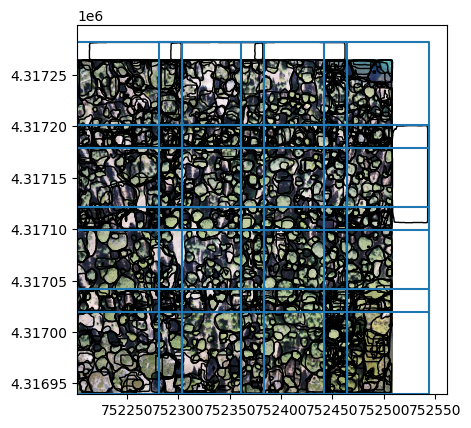

<Axes: >

In [7]:
predictions.plot(
    raster_file="/ofo-share/scratch-amritha/emerald_point_dtree2/dataset/emerald-point-ortho/ortho.tif"
)

2024-11-14 17:29:16,527 - INFO - Bound have overlap, running across-region NMS


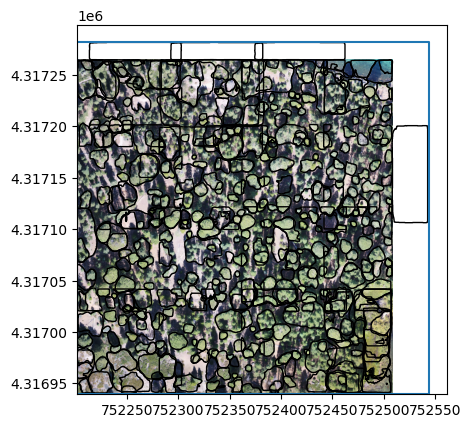

<Axes: >

In [8]:
NMS_outputs = multi_region_NMS(
    predictions, confidence_column="score", min_confidence=0.25, iou_theshold=0.5
)
NMS_outputs.plot(
    raster_file="/ofo-share/scratch-amritha/emerald_point_dtree2/dataset/emerald-point-ortho/ortho.tif"
)

Initial code for predict_batch
--

In [1]:
import os
import torch

import numpy as np
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.evaluation.coco_evaluation import instances_to_coco_json

from torchgeo.datasets import unbind_samples
import matplotlib.pyplot as plt

from tree_detection_framework.utils.geometric import mask_to_shapely
import geopandas as gpd

In [2]:
from tree_detection_framework.preprocessing.preprocessing import create_dataloader

/ofo-share/repos-amritha/conda/envs/tree-detection-framework2/lib/python3.10/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


In [3]:
dataloader = create_dataloader(
    raster_folder_path="/ofo-share/scratch-amritha/emerald_point_dtree2/dataset/emerald-point-ortho",
    # raster_folder_path="/ofo-share/scratch-derek/tdf-testing/",
    chip_size=512,
    chip_stride=400,
    batch_size=3,
    output_resolution=0.2,
)

In [4]:
def setup_cfg(
    base_model: str = "COCO-InstanceSegmentation/mask_rcnn_R_101_FPN_3x.yaml",
    trains=("trees_train",),
    tests=("trees_val",),
    update_model=None,
    workers=2,
    ims_per_batch=2,
    gamma=0.1,
    backbone_freeze=3,
    warm_iter=120,
    momentum=0.9,
    batch_size_per_im=1024,
    base_lr=0.0003389,
    weight_decay=0.001,
    max_iter=1000,
    num_classes=1,
    eval_period=100,
    out_dir="./train_outputs",
    resize=True,
):
    """Set up config object # noqa: D417.

    Args:
        base_model: base pre-trained model from detectron2 model_zoo
        trains: names of registered data to use for training
        tests: names of registered data to use for evaluating models
        update_model: updated pre-trained model from detectree2 model_garden
        workers: number of workers for dataloader
        ims_per_batch: number of images per batch
        gamma: gamma for learning rate scheduler
        backbone_freeze: backbone layer to freeze
        warm_iter: number of iterations for warmup
        momentum: momentum for optimizer
        batch_size_per_im: batch size per image
        base_lr: base learning rate
        weight_decay: weight decay for optimizer
        max_iter: maximum number of iterations
        num_classes: number of classes
        eval_period: number of iterations between evaluations
        out_dir: directory to save outputs
    """
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file(base_model))
    cfg.DATASETS.TRAIN = trains
    cfg.DATASETS.TEST = tests
    cfg.DATALOADER.NUM_WORKERS = workers
    cfg.SOLVER.IMS_PER_BATCH = ims_per_batch
    cfg.SOLVER.GAMMA = gamma
    cfg.MODEL.BACKBONE.FREEZE_AT = backbone_freeze
    cfg.SOLVER.WARMUP_ITERS = warm_iter
    cfg.SOLVER.MOMENTUM = momentum
    cfg.MODEL.RPN.BATCH_SIZE_PER_IMAGE = batch_size_per_im
    cfg.SOLVER.WEIGHT_DECAY = weight_decay
    cfg.SOLVER.BASE_LR = base_lr
    cfg.OUTPUT_DIR = out_dir
    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
    if update_model is not None:
        cfg.MODEL.WEIGHTS = update_model
    else:
        cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(base_model)

    cfg.SOLVER.IMS_PER_BATCH = ims_per_batch
    cfg.SOLVER.BASE_LR = base_lr
    cfg.SOLVER.MAX_ITER = max_iter
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = num_classes
    cfg.TEST.EVAL_PERIOD = eval_period
    cfg.RESIZE = resize
    cfg.INPUT.MIN_SIZE_TRAIN = 1000
    return cfg

In [5]:
all_batches = list(dataloader)

/ofo-share/repos-amritha/conda/envs/tree-detection-framework2/lib/python3.10/site-packages/rasterio/merge.py:369: NodataShadowWarning: The dataset's nodata attribute is shadowing the alpha band. All masks will be determined by the nodata attribute
  temp_src = src.read(


In [6]:
# all_batches[0]['image'].shape

In [7]:
# for batch in dataloader:
#     images = batch['image']
#     for image in images:
#         image = image.permute(1, 2, 0).byte().numpy()
#         original_image = image[:, :, :3]

In [6]:
class DefaultBatchPredictor(DefaultPredictor):

    def __call__(self, batch):
        """
        Args:
            original_image (np.ndarray): an image of shape (H, W, C) (in BGR order).

        Returns:
            predictions (dict):
                the output of the model for one image only.
                See :doc:`/tutorials/models` for details about the format.
        """
        with torch.no_grad():  # https://github.com/sphinx-doc/sphinx/issues/4258

            inputs = []
            for original_image in batch:
                original_image = original_image.permute(1, 2, 0).byte().numpy()
                original_image = original_image[:, :, :3]
                print("Original image shape = ", original_image.shape)

                # Apply pre-processing to image.
                if self.input_format == "RGB":
                    print("input format = ", self.input_format)
                    # whether the model expects BGR inputs or RGB
                    original_image = original_image[:, :, ::-1]
                height, width = original_image.shape[:2]
                image = self.aug.get_transform(original_image).apply_image(
                    original_image
                )
                image = torch.as_tensor(image.astype("float32").transpose(2, 0, 1))
                image.to(self.cfg.MODEL.DEVICE)
                print("Final image shape = ", image.shape)
                input = {"image": image, "height": height, "width": width}
                inputs.append(input)

            batch_preds = self.model(inputs)
            return batch_preds

In [7]:
trained_model = "/ofo-share/repos-amritha/detectree2-code/230103_randresize_full.pth"  # Load pretrained weights from local
cfg = setup_cfg(update_model=trained_model)

In [8]:
predictor = DefaultBatchPredictor(cfg)

/ofo-share/repos-amritha/conda/envs/tree-detection-framework2/lib/python3.10/site-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ret

In [ ]:
def predict_batch(batch):
    images = batch["image"]
    batch_preds = predictor(images)

    all_geometries = []
    all_data_dicts = []

    for pred in batch_preds:
        instances = pred["instances"].to("cpu")

        pred_masks = instances.pred_masks.numpy()
        shapely_objects = [mask_to_shapely(pred_mask) for pred_mask in pred_masks]
        all_geometries.append(shapely_objects)

        scores = instances.scores.numpy()
        labels = instances.pred_classes.numpy()
        all_data_dicts.append({"score": scores, "labels": labels})

    return all_geometries, all_data_dicts


all_geometries, all_data_dicts = predict_batch(all_batches[0])

Original image shape =  (512, 512, 3)
Final image shape =  torch.Size([3, 800, 800])
Original image shape =  (512, 512, 3)
Final image shape =  torch.Size([3, 800, 800])
Original image shape =  (512, 512, 3)
Final image shape =  torch.Size([3, 800, 800])


/ofo-share/repos-amritha/conda/envs/tree-detection-framework2/lib/python3.10/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [10]:
len(all_data_dicts[0]["labels"])

100